In [2]:
import os
total_images = 0
base_dir = r"/Users/fatimatuzzahra/Downloads/processed_slices/train"

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith('.png'):
            total_images += 1

print("Total images in testing folder:", total_images)


Total images in testing folder: 84825


In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import torch
import clip
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.ensemble import RandomForestClassifier

In [4]:
base_dir = r"/Users/fatimatuzzahra/Downloads/processed_slices/train"
class_names = ['AD', 'CN', 'MCI']
total_images = 0

for class_name in class_names:
    path = os.path.join(base_dir, class_name, 'axial')
    if os.path.exists(path):
        num_files = len([f for f in os.listdir(path) if f.lower().endswith('.png')])
        print(f"{class_name} axial images: {num_files}")
        total_images += num_files
    else:
        print(f" Path not found: {path}")

print("Total axial images:", total_images)


AD axial images: 17575
CN axial images: 25795
MCI axial images: 41455
Total axial images: 84825


In [5]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("cpu")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cpu


In [6]:
import torch, torchvision
print("Torch:", torch.__version__)
print("TorchVision:", torchvision.__version__)

Torch: 2.7.0
TorchVision: 0.22.0


In [ ]:
import torch
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as T
from monai.networks.nets import DenseNet121
from monai.transforms import Compose, LoadImage, Resize, ScaleIntensity, EnsureChannelFirst, ToTensor
from torchvision.models import densenet121, DenseNet121_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# ---- Model ----
weights = DenseNet121_Weights.DEFAULT 
model = densenet121(weights=weights)
full_model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=1, pretrained=True)
feature_extractor = torch.nn.Sequential(*list(full_model.children())[:-1]).to(device)
feature_extractor.eval()

# ---- Transforms ----
class RepeatChannel:
    def __call__(self, img):
        if isinstance(img, np.ndarray):
            img = torch.tensor(img)
        if img.shape[0] == 1:
            return img.repeat(3, 1, 1)
        return img

transform = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Resize((224, 224)),
    ScaleIntensity(),
    ToTensor(),
    RepeatChannel()
])

augmenter = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    RepeatChannel(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# ---- Paths and Labels ----
base_dir = r"/Users/fatimatuzzahra/Downloads/processed_slices/train"
classes = ['AD', 'CN', 'MCI']
label_map = {cls: idx for idx, cls in enumerate(classes)}

# ---- Mini-batch params ----
BATCH_SIZE = 64

for cls in classes:
    print(f"\nProcessing class: {cls}")
    class_dir = os.path.join(base_dir, cls, 'axial')
    if not os.path.exists(class_dir):
        print(f"Directory not found: {class_dir}")
        continue

    features, labels, image_paths = [], [], []
    file_list = [f for f in os.listdir(class_dir) if f.lower().endswith('.png')]

    for i in tqdm(range(0, len(file_list), BATCH_SIZE), desc=f"Class {cls}"):
        batch_filenames = file_list[i:i + BATCH_SIZE]
        orig_batch, aug_batch = [], []
        batch_paths, batch_labels = [], []

        for fname in batch_filenames:
            img_path = os.path.join(class_dir, fname)
            try:
                # Original
                monai_img = transform(img_path).unsqueeze(0)  # shape: [1, 3, 224, 224]
                orig_batch.append(monai_img)
                batch_labels.append(label_map[cls])
                batch_paths.append(img_path)

                # Augmented
                pil_img = Image.open(img_path).convert("L")
                aug_img = augmenter(pil_img).unsqueeze(0)
                aug_batch.append(aug_img)
                batch_labels.append(label_map[cls])
                batch_paths.append(img_path + "_aug")

            except Exception as e:
                print(f"Failed to process {img_path}: {e}")

        # Stack and send to device
        if orig_batch:
            orig_batch_tensor = torch.cat(orig_batch).to(device)
            aug_batch_tensor = torch.cat(aug_batch).to(device)

            with torch.no_grad():
                orig_feats = feature_extractor(orig_batch_tensor).cpu().numpy()
                aug_feats = feature_extractor(aug_batch_tensor).cpu().numpy()

            all_feats = np.concatenate([orig_feats, aug_feats], axis=0)
            features.extend(all_feats)
            labels.extend(batch_labels)
            image_paths.extend(batch_paths)

    # Save after processing each class
    np.save(f"features_{cls}.npy", np.array(features))
    np.save(f"labels_{cls}.npy", np.array(labels))
    np.save(f"image_paths_{cls}.npy", np.array(image_paths))

    print(f"✅ Saved: features_{cls}.npy | labels_{cls}.npy | image_paths_{cls}.npy")

In [ ]:
features_AD = np.load("features_AD.npy")
features_CN = np.load("features_CN.npy")
features_MCI = np.load("features_MCI.npy")

# Flatten: (35150, 1024, 7, 7) → (35150, 1024 * 7 * 7)
features_AD = features_AD.reshape(features_AD.shape[0], -1)
features_CN = features_CN.reshape(features_CN.shape[0], -1)
features_MCI = features_MCI.reshape(features_MCI.shape[0], -1)

In [ ]:
import numpy as np
from sklearn.utils import shuffle


# Labels
labels_AD = np.full(len(features_AD), 0)    # Alzheimer's Disease
labels_CN = np.full(len(features_CN), 1)    # Cognitively Normal
labels_MCI = np.full(len(features_MCI), 2)  # Mild Cognitive Impairment

features_AD = features_AD.astype(np.float16)
features_CN = features_CN.astype(np.float16)
features_MCI = features_MCI.astype(np.float16)

# Concatenate features and labels
all_features = np.concatenate([features_AD, features_CN, features_MCI], axis=0)
all_labels = np.concatenate([labels_AD, labels_CN, labels_MCI], axis=0)

print("All features shape:", all_features.shape)
print("All labels shape:", all_labels.shape)



In [ ]:
np.save("train_features_axial_monai.npy", all_features)
np.save("train_labels_axial_monai.npy", all_labels)

print("Feature vectors saved:")
print("train_features_axial_monai.npy")
print("train_labels_axial_monai.npy")

same process as above for validation data

In [ ]:
import os
import numpy as np
from tqdm import tqdm
# import imgaug.augmenters as iaa
# from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
import torchvision.transforms as T
from monai.networks.nets import DenseNet121
from monai.transforms import Compose, LoadImage, Resize, ScaleIntensity, EnsureChannelFirst, ToTensor
from PIL import Image
from torchvision.models import densenet121, DenseNet121_Weights


# Extracting MONAI Image features

weights = DenseNet121_Weights.DEFAULT 
model = densenet121(weights=weights)
full_model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=1, pretrained=True)

# Remove classifier (keep features before final dense layer)
feature_extractor = torch.nn.Sequential(*list(full_model.children())[:-1]).to(device)
feature_extractor.eval()

class RepeatChannel:
    def __call__(self, img):
        if isinstance(img, np.ndarray):
            img = torch.tensor(img)
        if img.shape[0] == 1:
            return img.repeat(3, 1, 1)
        return img

# --- MONAI Transform for original grayscale image ---
transform = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),       # Shape: [1, H, W]
    Resize((224, 224)),
    ScaleIntensity(),
    ToTensor(),
    RepeatChannel()             # Now shape becomes [3, H, W]
])

# --- Torch augmentations for grayscale input ---
augmenter = T.Compose([
    T.Grayscale(num_output_channels=1),        # Enforce 1 channel
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),                               # -> [1, H, W]
    RepeatChannel(),                            # -> [3, H, W]
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Standard normalization
])

# EfficientNet base model
# base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
# # Step 3: Build feature extractor model (outputs 256-dim feature vectors)
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu')(x)
# feature_extractor = Model(inputs=base_model.input, outputs=x)

# Step 4: Setup paths and label mapping
base_dir = r"/Users/fatimatuzzahra/Downloads/processed_slices/val"
classes = ['AD', 'CN', 'MCI']
label_map = {cls: idx for idx, cls in enumerate(classes)}

features, labels, image_paths = [], [], []

# Step 5: Loop through dataset and extract features

for cls in classes:
    print(cls)
    class_dir = os.path.join(base_dir, cls, 'axial')
    if not os.path.exists(class_dir):
        print(f"Directory not found: {class_dir}")
        continue

    for fname in tqdm(os.listdir(class_dir), desc=f"Processing {cls}"):
        if fname.lower().endswith('.png'):
            img_path = os.path.join(class_dir, fname)
            try:
                # --------- Original Image (Grayscale assumed) ---------
                monai_img = transform(img_path).unsqueeze(0).to(device)  # shape: [1, 3, 224, 224]
                with torch.no_grad():
                    orig_feat = feature_extractor(monai_img).cpu().numpy().flatten()
                features.append(orig_feat)
                labels.append(label_map[cls])
                image_paths.append(img_path)

                # --------- Augmented Image  ---------
                pil_img = Image.open(img_path).convert("L")
                aug_img_tensor = augmenter(pil_img).unsqueeze(0).to(device)  # shape: [1, 3, 224, 224]
                with torch.no_grad():
                    aug_feat = feature_extractor(aug_img_tensor).cpu().numpy().flatten()
                features.append(aug_feat)
                labels.append(label_map[cls])
                image_paths.append(img_path + "_aug")

            except Exception as e:
                print(f"Failed to process {img_path}: {e}")

# Step 6: Save features, labels, and paths
features = np.array(features)
labels = np.array(labels)
image_paths = np.array(image_paths)

np.save("val_features_axial_monai.npy", features)
np.save("val_labels_axial_monai.npy", labels)
np.save("val_image_paths_axial_monai.npy", image_paths)

print("Feature vectors saved:")
print("val_features_axial_monai.npy")
print("val_labels_axial_monai.npy")
print("val_image_paths_axial_monai.npy")

In [8]:
features = np.load("train_features_axial_monai.npy")       # Shape: (84755, 256)
print(features.shape)
labels = np.load("train_labels_axial_monai.npy")           # Shape: (84755,)
print(labels.shape)
# image_paths = np.load("train_image_paths_axial_monai.npy") # Shape: (84755,)
# print(image_paths.shape)


(169650, 50176)
(169650,)


loading and printing features and other things for validation data as well

In [7]:
features = np.load("val_features_axial_monai.npy")       # Shape: (84755, 256)
print(features.shape)
labels = np.load("val_labels_axial.npy")           # Shape: (84755,)
print(labels.shape)
image_paths = np.load("val_image_paths_axial.npy") # Shape: (84755,)
print(image_paths.shape)


(16830, 50176)
(8415,)
(8415,)


In [ ]:
X_train = np.load("train_features_axial_monai.npy")
y_train = np.load("train_labels_axial_monai.npy")
X_val = np.load("val_features_axial_monai.npy")

In [ ]:
X_small = X_train[:20000]  # or fewer
y_small = y_train[:20000]

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_small, y_small)

Processing chunk 1/10
Processing chunk 2/10
Processing chunk 3/10
Processing chunk 4/10
Processing chunk 5/10
Processing chunk 6/10
Processing chunk 7/10
Processing chunk 8/10
Processing chunk 9/10
Processing chunk 10/10


Text(0, 0.5, 'Importance')

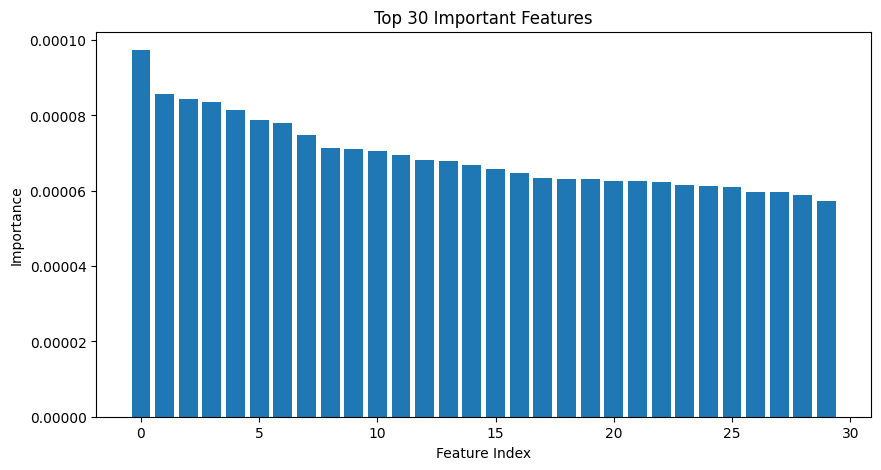

In [ ]:
import numpy as np
import joblib
import gc

X_train = np.load("train_features_axial_monai.npy", mmap_mode='r')  # read without loading all
y_train = np.load("train_labels_axial_monai.npy")
X_val = np.load("val_features_axial_monai.npy")

n_chunks = 10
chunk_size = X_train.shape[0] // n_chunks

feature_importances = np.zeros(X_train.shape[1])

for i in range(n_chunks):
    print(f"Processing chunk {i+1}/{n_chunks}")
    start = i * chunk_size
    end = (i + 1) * chunk_size if i < n_chunks - 1 else X_train.shape[0]
    
    X_chunk = X_train[start:end]
    y_chunk = y_train[start:end]

    rf = RandomForestClassifier(n_estimators=25, random_state=42+i, n_jobs=-1)
    rf.fit(X_chunk, y_chunk)
    feature_importances += rf.feature_importances_
    del rf
    gc.collect()

# Average importances over chunks
feature_importances /= n_chunks

# Top features
top_indices = np.argsort(feature_importances)[::-1][:30]
np.save("rf_top30_indices.npy", top_indices)
X_train_reduced = X_train[:, top_indices]
X_val_reduced = X_val[:, top_indices]  # Do the same for test/val sets

# Save reduced datasets
np.save("X_train_reduced_monai.npy", X_train_reduced)
np.save("X_val_reduced_monai.npy", X_val_reduced)

# Save selected feature indices for future use
joblib.dump(top_indices, "selected_rf_indices_monai.pkl")
X_train_reduced = X_train[:, top_indices]
X_test_reduced = X_val[:, top_indices]  # Do the same for test/val sets
plt.figure(figsize=(10, 5))
plt.bar(range(len(top_indices)), feature_importances[top_indices])
plt.title("Top 30 Important Features")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


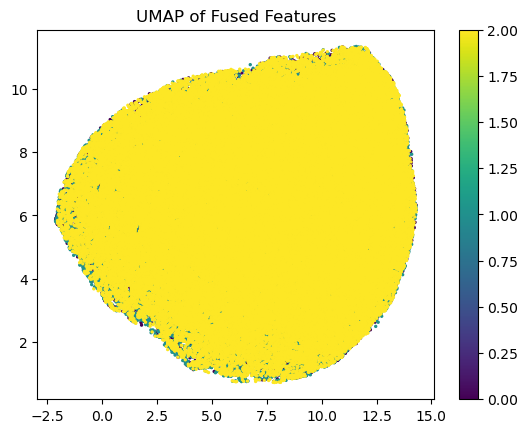

In [10]:
# for visualisation
import umap.umap_ as umap

X_train_reduced = np.load("X_train_reduced_monai.npy")
y_train = np.load("train_labels_axial_monai.npy")
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_train_reduced)

# Visualize 2D UMAP
import matplotlib.pyplot as plt
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_train, cmap="viridis", s=2)
plt.title("UMAP of Fused Features")
plt.colorbar()
plt.show()

In [12]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 35150, 1: 51590, 2: 82910}


In [ ]:
# Undersampled balanced
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = rus.fit_resample(X_train_reduced, y_train)

# Then re-run UMAP
X_umap_bal = reducer.fit_transform(X_balanced)

In [ ]:
# Supervised UMAP
reducer = umap.UMAP(n_components=2, random_state=42, target_metric='categorical')
X_umap_supervised = reducer.fit_transform(X_balanced, y_balanced)

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


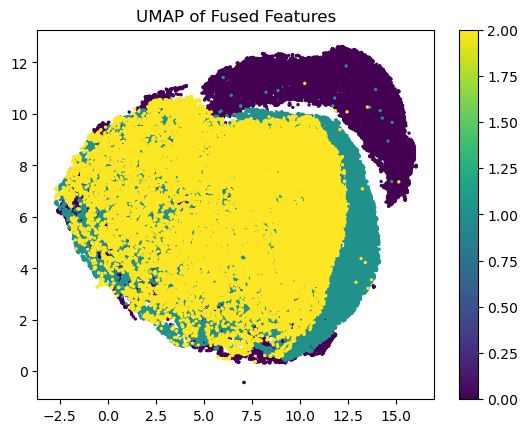

In [19]:
# Visualize 2D UMAP
import matplotlib.pyplot as plt
plt.scatter(X_umap_supervised[:, 0], X_umap_supervised[:, 1], c=y_balanced, cmap="viridis", s=2)
plt.title("UMAP of Fused Features")
plt.colorbar()
plt.show()

In [8]:
# Load the .npy files
import pandas as pd
features = np.load("X_train_reduced_monai.npy")       
labels = np.load("train_labels_axial_monai.npy")           

# Combine features and labels
combined = np.hstack((features, labels.reshape(-1, 1)))  

# Create a DataFrame
df = pd.DataFrame(combined)

# Optionally name columns

feature_columns = [f"f{i}" for i in range(features.shape[1])]
df.columns = feature_columns + ["label"]

# Save to CSV
df.to_csv("train_axial_features_and_labels_only_monai.csv", index=False)

print(" Saved: train_axial_features_and_labels_only_monai.csv")


 Saved: train_axial_features_and_labels_only_monai.csv


same process for validation set

In [9]:
# Load the .npy files
features = np.load("X_val_reduced_monai.npy")       # Shape: (84755, 256)
labels = np.load("val_labels_axial_monai.npy")           # Shape: (84755,)

# Combine features and labels
combined = np.hstack((features, labels.reshape(-1, 1)))  # Shape: (84755, 257)

# Create a DataFrame
df = pd.DataFrame(combined)

# Optionally name columns
feature_columns = [f"f{i}" for i in range(features.shape[1])]
df.columns = feature_columns + ["label"]

# Save to CSV
df.to_csv("val_axial_features_and_labels_only_monai.csv", index=False)

print(" Saved: val_axial_features_and_labels_only_monai.csv")


 Saved: val_axial_features_and_labels_only_monai.csv


In [7]:
# for text embeddings
import pandas as pd

# Load your file
df = pd.read_csv("/Users/fatimatuzzahra/Downloads/ADNI1_Merged_AllImages.csv")

# Preview the first few rows
print(df.shape)
df.head()


(2294, 51)


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,...,AXCRYING,AXELMOOD,AXWANDER,AXFALL,AXOTHER,ID,SITEID,USERDATE,USERDATE2,update_stamp
0,I112538,941_S_1311,MCI,M,70,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/1/2008,...,1.0,1.0,1.0,1.0,1.0,4150.0,127.0,5/5/2008,NaN,00:00.0
1,I97341,941_S_1311,MCI,M,70,m06,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,9/27/2007,...,1.0,1.0,1.0,1.0,2.0,2370.0,127.0,9/18/2007,NaN,00:00.0
2,I97327,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/2/2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I63874,941_S_1202,CN,M,78,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,1/30/2007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,I75150,941_S_1202,CN,M,78,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/24/2007,...,1.0,1.0,1.0,2.0,1.0,2110.0,127.0,8/15/2007,NaN,00:00.0


In [13]:
import pandas as pd

# Remove label 
df_cleaned = df.drop(columns=["Group", "Downloaded", "Modality", "Type", "Format"])

# Keep Image ID separately for future mapping
image_ids = df_cleaned["Image Data ID"].values

# Drop ID from the text encoding input
text_only = df_cleaned.drop(columns=["Image Data ID"])

# Convert each row to string and generate sentence embeddings
texts = text_only.astype(str).agg(" ".join, axis=1).tolist()
texts = [t.lower().strip() for t in texts]

# Tokenize all text using CLIP
text_tokens = clip.tokenize(texts, truncate=True).to(device)

# Generate text embeddings
with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens).cpu().numpy()  # shape: (n_samples, 512)
# Save with Image IDs
import numpy as np
np.save("text_embeddings_cleaned.npy", text_embeddings)
np.save("text_image_ids.npy", image_ids)


In [14]:
import numpy as np
import pandas as pd

# Load the cleaned text embeddings and associated image IDs
text_embeddings = np.load("text_embeddings_cleaned.npy")           # shape: (2294, 384)
text_image_ids = np.load("text_image_ids.npy", allow_pickle=True)  # shape: (2294,)

# Convert to DataFrame and add IDs as the first column
df = pd.DataFrame(text_embeddings)
df.insert(0, "Image_ID", text_image_ids)

# Save to CSV
df.to_csv("text_embeddings_cleaned_with_ids_monai.csv", index=False)

print(" Saved: text_embeddings_cleaned_with_ids_monai.csv")
print(" Shape:", df.shape)


 Saved: text_embeddings_cleaned_with_ids_monai.csv
 Shape: (2294, 513)


In [ ]:
image_features = np.load("X_train_reduced_monai.npy")  
print(image_features.shape)

In [21]:
import numpy as np
from tqdm import tqdm
import os

# Load image feature data
image_features = np.load("X_train_reduced_monai.npy")      
image_labels = np.load("train_labels_axial_monai.npy")     
image_paths = np.load("train_image_paths_axial.npy")      

# Load cleaned textual embeddings and IDs
textual_embeddings = np.load("text_embeddings_cleaned.npy")   # (2294, 384)
text_ids = np.load("text_image_ids.npy", allow_pickle=True)      # (2294,)

# Step 1: Build a lookup from Image ID → text embedding
text_lookup = {id_: emb for id_, emb in zip(text_ids, textual_embeddings)}

# Step 2: Match each image with its text embedding (based on ID prefix)
fused_features = []
fused_labels = []
matched_count = 0

for i, (img_feat, label, path) in enumerate(tqdm(zip(image_features, image_labels, image_paths), total=len(image_paths))):
    filename = os.path.basename(path)  # e.g., 'I31143_AD_axial_55.png'
    img_id = filename.split('_')[0]             # 'I31143'

    if img_id in text_lookup:
        text_feat = text_lookup[img_id]
        fused = np.concatenate([img_feat, text_feat])  # shape (640,)
        fused_features.append(fused)
        fused_labels.append(label)
        matched_count += 1

print(f" Matched samples: {matched_count}")

# Convert to arrays and save
fused_features = np.array(fused_features)
fused_labels = np.array(fused_labels)

np.save("train_fused_features_clean_monai.npy", fused_features)
np.save("train_fused_labels_clean_monai.npy", fused_labels)

print(" Final train fused shape:", fused_features.shape)
print(" Labels shape:", fused_labels.shape)


100%|██████████| 169650/169650 [00:00<00:00, 442467.39it/s]


 Matched samples: 169650
 Final train fused shape: (169650, 542)
 Labels shape: (169650,)


fusion for the validation set is done below

In [23]:
import numpy as np
from tqdm import tqdm
import os

# Load image feature data
image_features = np.load("X_val_reduced_monai.npy")       # (84755, 256)
image_labels = np.load("val_labels_axial_monai.npy")           # (84755,)
image_paths = np.load("val_image_paths_axial.npy")       # (84755,)

# Load cleaned textual embeddings and IDs
textual_embeddings = np.load("text_embeddings_cleaned.npy")   # (2294, 384)
text_ids = np.load("text_image_ids.npy", allow_pickle=True)      # (2294,)

# Step 1: Build a lookup from Image ID → text embedding
text_lookup = {id_: emb for id_, emb in zip(text_ids, textual_embeddings)}

# Step 2: Match each image with its text embedding (based on ID prefix)
fused_features = []
fused_labels = []
matched_count = 0

for i, (img_feat, label, path) in enumerate(tqdm(zip(image_features, image_labels, image_paths), total=len(image_paths))):
    filename = os.path.basename(path)  # e.g., 'I31143_AD_axial_55.png'
    img_id = filename.split('_')[0]             # 'I31143'

    if img_id in text_lookup:
        text_feat = text_lookup[img_id]
        fused = np.concatenate([img_feat, text_feat])  # shape (640,)
        fused_features.append(fused)
        fused_labels.append(label)
        matched_count += 1

print(f" Matched samples: {matched_count}")

# Convert to arrays and save
fused_features = np.array(fused_features)
fused_labels = np.array(fused_labels)

np.save("val_fused_features_clean_monai.npy", fused_features)
np.save("val_fused_labels_clean_monai.npy", fused_labels)

print(" Final val fused shape:", fused_features.shape)
print(" Labels shape:", fused_labels.shape)


100%|██████████| 8415/8415 [00:00<00:00, 224616.21it/s]

 Matched samples: 8415
 Final val fused shape: (8415, 542)
 Labels shape: (8415,)


In [24]:
import numpy as np
import pandas as pd

# Load
X = np.load("train_fused_features_clean_monai.npy")
y = np.load("train_fused_labels_clean_monai.npy")

# Combine into DataFrame
df = pd.DataFrame(X)
df["label"] = y

# Save to CSV
df.to_csv("train_fused_embeddings_with_labels_monai.csv", index=False)
print(" Saved: train_fused_embeddings_with_labels_monai.csv")


 Saved: train_fused_embeddings_with_labels_monai.csv


savinf into csv the validation fused sets

In [ ]:
import numpy as np
import pandas as pd

# Load
X = np.load("val_fused_features_clean_monai.npy")
y = np.load("val_fused_labels_clean_monai.npy")

# Combine into DataFrame
df = pd.DataFrame(X)
df["label"] = y

# Save to CSV
df.to_csv("val_fused_embeddings_with_labels_monai.csv", index=False)
print(" Saved: val_fused_embeddings_with_labels_monai.csv")


 Saved: val_fused_embeddings_with_labels_monai.csv


In [30]:
print(y.shape)

(8415,)


saving image and textual data separately for training dataset

In [26]:
import numpy as np

# Load fused embeddings
fused = np.load("train_fused_features_clean_monai.npy")  # (84755, 640)

# Split features
image_features = fused[:, :256]   # CNN-based
text_features  = fused[:, 256:]   # Sentence-transformer-based

# Save separately
np.save("train_image_features_only_monai.npy", image_features)
np.save("train_text_features_only_monai.npy", text_features)

print(" Saved:")
print("  train_image_features_only_monai.npy (shape:", image_features.shape, ")")
print("  train_text_features_only_monai.npy  (shape:", text_features.shape, ")")


 Saved:
  train_image_features_only_monai.npy (shape: (169650, 256) )
  train_text_features_only_monai.npy  (shape: (169650, 286) )


saving image and textual data separately for validation dataset

In [27]:
import numpy as np

# Load fused embeddings
fused = np.load("val_fused_features_clean_monai.npy")  # (84755, 640)

# Split features
image_features = fused[:, :256]   # CNN-based
text_features  = fused[:, 256:]   # Sentence-transformer-based

# Save separately
np.save("val_image_features_only_monai.npy", image_features)
np.save("val_text_features_only_monai.npy", text_features)

print(" Saved:")
print("  val_image_features_only_monai.npy (shape:", image_features.shape, ")")
print("  val_text_features_only_monai.npy  (shape:", text_features.shape, ")")


 Saved:
  val_image_features_only_monai.npy (shape: (8415, 256) )
  val_text_features_only_monai.npy  (shape: (8415, 286) )


In [29]:
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{0: 3740, 1: 4675}


In [ ]:
import torch.nn as nn

class MLPWithDropout(nn.Module):
    def __init__(self):
        super(MLPWithDropout, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1024, 512),   # input size must match your fused feature size (e.g., 1024 if CLIP image+text)
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 3)       # 3 output classes (AD, CN, MCI)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import torch.nn as nn
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
import torch 
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Load data
X_train = np.load("train_fused_features_clean.npy")
y_train = np.load("train_fused_labels_clean.npy")
X_val = np.load("val_fused_features_clean.npy")
y_val = np.load("val_fused_labels_clean.npy")

# Optional: if your MLP has 1024 input, pad image/text features accordingly
# assert X_train.shape[1] == 1024

# Scale inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_bal, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_bal, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)



model = MLPWithDropout().to("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"


for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

# ros = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
import gc
gc.collect()
torch.cuda.empty_cache()

# 🔹 Evaluate on Training Set
model.eval()
y_train_preds = []
y_train_true = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(device)
        out = model(xb)
        preds = torch.argmax(out, dim=1)
        y_train_preds.extend(preds.cpu().numpy())
        y_train_true.extend(yb.numpy())

# Training Metrics
train_acc = accuracy_score(y_train_true, y_train_preds)
print(f"📊 Training Accuracy: {train_acc:.4f}")

# 🔹 Evaluate on Validation Set
model.eval()
y_val_preds = []
y_val_true = []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        out = model(xb)
        preds = torch.argmax(out, dim=1)
        y_val_preds.extend(preds.cpu().numpy())
        y_val_true.extend(yb.numpy())

# Metrics
val_acc = accuracy_score(y_val_true, y_val_preds)
print(f"✅ Validation Accuracy: {val_acc:.4f}")
print("Classification Report:\n", classification_report(y_val_true, y_val_preds, target_names=["AD", "CN", "MCI"]))

# Confusion Matrix
cm = confusion_matrix(y_val_true, y_val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["AD", "CN", "MCI"], yticklabels=["AD", "CN", "MCI"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLP (Validation Set)")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Assuming y_test and y_pred are already defined from your previous evaluation

# Define class labels (you can update these if your label encoding is different)
class_names = ['AD', 'CN', 'MCI']

# Accuracy
accuracy = accuracy_score(y_val_true, y_val_preds)
print(f"\n Accuracy: {accuracy:.4f}")

# Precision, Recall, F1-score
print("\n Classification Report:")
print(classification_report(y_val_true, y_val_preds, target_names=class_names))
